In [ ]:
#python3 -m notebook
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
%pylab inline
from tqdm import tqdm
import pickle
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)


In [16]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

## Neural Network

In [10]:
import pickle
poss=[]
poss1=[]
poss2=[]
poss3=[]
poss4=[]
poss5=[]
poss6=[]
poss7=[]
poss8=[]
poss9=[]
poss10=[]
with open('poss.txt', 'rb') as f:
    poss=pickle.load(f)

with open('poss1.txt', 'rb') as f:
    poss1=pickle.load(f)

with open('poss2.txt', 'rb') as f:
    poss2=pickle.load(f)

with open('poss3.txt', 'rb') as f:
    poss3=pickle.load(f)

with open('poss4.txt', 'rb') as f:
    poss4=pickle.load(f)

with open('poss5.txt', 'rb') as f:
    poss5=pickle.load(f)

with open('poss6.txt', 'rb') as f:
    poss6=pickle.load(f)

with open('poss7.txt', 'rb') as f:
    poss7=pickle.load(f)

with open('poss8.txt', 'rb') as f:
    poss8=pickle.load(f)

with open('poss9.txt', 'rb') as f:
    poss9=pickle.load(f)

with open('poss10.txt', 'rb') as f:
    poss10=pickle.load(f)

In [11]:
vels=[]
vels1=[]
vels2=[]
vels3=[]
vels4=[]
vels5=[]
vels6=[]
vels7=[]
vels8=[]
vels9=[]
vels10=[]
scales=[]
with open('vels.txt', 'rb') as f:
    vels=pickle.load(f)

with open('vels1.txt', 'rb') as f:
    vels1=pickle.load(f)

with open('vels2.txt', 'rb') as f:
    vels2=pickle.load(f)

with open('vels3.txt', 'rb') as f:
    vels3=pickle.load(f)

with open('vels4.txt', 'rb') as f:
    vels4=pickle.load(f)

with open('vels5.txt', 'rb') as f:
    vels5=pickle.load(f)

with open('vels6.txt', 'rb') as f:
    vels6=pickle.load(f)

with open('vels7.txt', 'rb') as f:
    vels7=pickle.load(f)

with open('vels8.txt', 'rb') as f:
    vels8=pickle.load(f)

with open('vels9.txt', 'rb') as f:
    vels9=pickle.load(f)

with open('vels10.txt', 'rb') as f:
    vels10=pickle.load(f)

with open('scales.txt', 'rb') as f:
    scales=pickle.load(f)

In [26]:
import jax
import jax.numpy as jnp
import haiku as hk



class SpectralConv3x(hk.Module):
  """Attempt"""

  def __init__(self, in_channels=1, out_channels=1, modes1=32, modes2=32, modes3=32, is_training=True, name='Layer'):

    super().__init__(name=name)
    self.name= name
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
    self.modes2 = modes2
    self.modes3 = modes3
    
    self.scale = (1 / (self.in_channels * self.out_channels))
    self.weights1= hk.get_parameter(str(self.name)+ "w1", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights2= hk.get_parameter(str(self.name)+ "w2", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights3= hk.get_parameter(str(self.name)+ "w3", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())
    self.weights4= hk.get_parameter(str(self.name)+ "w4", shape=[in_channels, out_channels, self.modes1, self.modes2, self.modes3], dtype=float, init=hk.initializers.VarianceScaling())


  def __call__(self, pot_k):

    def compl_mul3d(input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return jnp.einsum("bixyz,ioxyz->boxyz", input, weights)
    
  
        
    self.weights1=self.weights1*self.scale
    self.weights2=self.weights2*self.scale
    self.weights3=self.weights3*self.scale
    self.weights4=self.weights4*self.scale

    batchsize=1
    
    
    #x_ft=x_ft.reshape(1,1,64,64,33)
    x_ft=pot_k
    
    _,_,dim1,dim2,dim3=x_ft.shape
    
    out_ft=jnp.zeros([batchsize, self.out_channels, dim1, dim2, dim3], dtype=float)
    out_ft=out_ft.at[:, :, :self.modes1, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1))

    out_ft=out_ft.at[:, :, -self.modes1:, :self.modes2, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2))

    out_ft=out_ft.at[:, :, :self.modes1, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3))

    out_ft=out_ft.at[:, :, -self.modes1:, -self.modes2:, :self.modes3]. \
    set(compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4))

    

    return out_ft

In [27]:


# Instantiate the neural network
input_ch=20
modes=8
model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3x()(x)))

params = model.init(next(rng_seq),jnp.zeros((1,1,64,64,33)))

In [28]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k[jax.numpy.newaxis,jax.numpy.newaxis,...]
    pot_k = pot_k + model.apply(params, pot_k)
    pot_k = np.squeeze(pot_k)
    print(pot_k.shape)
    #print(model.apply(params, kk, jnp.atleast_1d(a)))
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [29]:
import collections
from functools import partial
def ref_pk_fun(ref):
    return jax.vmap(lambda x: power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), x)),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)[1])(ref)

ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pos1 = jnp.stack(poss1, axis=0)
ref_vel1 = jnp.stack(vels1, axis=0)
ref_pos2 = jnp.stack(poss2, axis=0)
ref_vel2 = jnp.stack(vels2, axis=0)
ref_pos3 = jnp.stack(poss3, axis=0)
ref_vel3 = jnp.stack(vels3, axis=0)
ref_pos4 = jnp.stack(poss4, axis=0)
ref_vel4 = jnp.stack(vels4, axis=0)
ref_pos5 = jnp.stack(poss5, axis=0)
ref_vel5 = jnp.stack(vels5, axis=0)
ref_pos6 = jnp.stack(poss6, axis=0)
ref_vel6 = jnp.stack(vels6, axis=0)
ref_pos7 = jnp.stack(poss7, axis=0)
ref_vel7 = jnp.stack(vels7, axis=0)
ref_pos8 = jnp.stack(poss8, axis=0)
ref_vel8 = jnp.stack(vels8, axis=0)
ref_pos9 = jnp.stack(poss9, axis=0)
ref_vel9 = jnp.stack(vels9, axis=0)
ref_pos10 = jnp.stack(poss10, axis=0)
ref_vel10 = jnp.stack(vels10, axis=0)

ref_pk = ref_pk_fun(ref_pos)
ref_pk1 = ref_pk_fun(ref_pos1)
ref_pk2 = ref_pk_fun(ref_pos2)
ref_pk3 = ref_pk_fun(ref_pos3)
ref_pk4 = ref_pk_fun(ref_pos4)
ref_pk5 = ref_pk_fun(ref_pos5)
ref_pk6 = ref_pk_fun(ref_pos6)
ref_pk7 = ref_pk_fun(ref_pos7)
ref_pk8 = ref_pk_fun(ref_pos8)
ref_pk9 = ref_pk_fun(ref_pos9)
ref_pk10 = ref_pk_fun(ref_pos10)



In [30]:
@jax.jit
def loss_fn(params,possX,velsX,scalesX,ref_posX,ref_pkX):
  def calc(params,possX,velsX,scalesX,ref_posX,ref_pkX):
    res = odeint(neural_nbody_ode, [possX[0], velsX[0]], jnp.array(scalesX), cosmo, params, rtol=1e-5, atol=1e-5)
    distance = jnp.sum((res[0] - ref_posX)**2, axis=-1)
    w = jnp.where(distance < 100, distance, 0.)
    pk = jax.vmap(lambda x: power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), x)),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)[1])(res[0])


    # This loss function contains a penalty on the position of the particles + we want the correct power spectrum
    return  jnp.mean(jnp.sum((pk/ref_pkX -1)**2,axis=-1)) +jnp.mean(w) 
  
  los=calc(params,possX,velsX,scalesX,ref_posX,ref_pkX)
  return los



@jax.jit
def update(params, opt_state,possX,velsX,scalesX,ref_posX,ref_velX):
    """Single SGD update step."""

    loss, grads = jax.value_and_grad(loss_fn)(params,possX,velsX,scalesX,ref_posX,ref_velX)

    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    test_loss, grads1 = jax.value_and_grad(loss_fn)(params,poss2,vels2,scales,ref_pos2,ref_pk2)
    return loss, new_params, new_opt_state,test_loss

In [32]:
losses = []
test_losses=[]

In [53]:

import optax
learning_rate=0.005
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [ ]:
for step in tqdm(range(1000)):
  if(step%10==0):
    l, params, opt_state,test_loss = update(params, opt_state,poss,vels,scales,ref_pos,ref_pk)
  elif(step%10==1):
    l, params, opt_state,test_loss = update(params, opt_state,poss1,vels1,scales,ref_pos1,ref_pk1)
  elif(step%10==2):
    l, params, opt_state,test_loss = update(params, opt_state,poss3,vels3,scales,ref_pos3,ref_pk3)
  elif(step%10==3):
    l, params, opt_state,test_loss = update(params, opt_state,poss4,vels4,scales,ref_pos4,ref_pk4)
  elif(step%10==4):
    l, params, opt_state,test_loss = update(params, opt_state,poss5,vels5,scales,ref_pos5,ref_pk5)
  elif(step%10==5):
    l, params, opt_state,test_loss = update(params, opt_state,poss6,vels6,scales,ref_pos6,ref_pk6)
  elif(step%10==6):
    l, params, opt_state,test_loss = update(params, opt_state,poss7,vels7,scales,ref_pos7,ref_pk7)
  elif(step%10==7):
    l, params, opt_state,test_loss = update(params, opt_state,poss8,vels8,scales,ref_pos8,ref_pk8)
  elif(step%10==8):
    l, params, opt_state,test_loss = update(params, opt_state,poss9,vels9,scales,ref_pos9,ref_pk9)
  elif(step%10==9):
    l, params, opt_state,test_loss = update(params, opt_state,poss10,vels10,scales,ref_pos10,ref_pk10)

  if(step%10==0):
    print("Step: ", step, " Loss: ",l ,"Test_loss: ", test_loss)
  losses.append(l)
  test_losses.append(test_loss)

In [ ]:
skip_loss=50
plt.plot(range(0,len(losses)-skip_loss), losses[skip_loss:], 'g', label='Label 1')
plt.plot(range(0,len(test_losses)-skip_loss), test_losses[skip_loss:] , 'b', label='Label 2')
legend('LT')

In [ ]:
res = odeint(neural_nbody_ode, [poss2[0], vels2[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

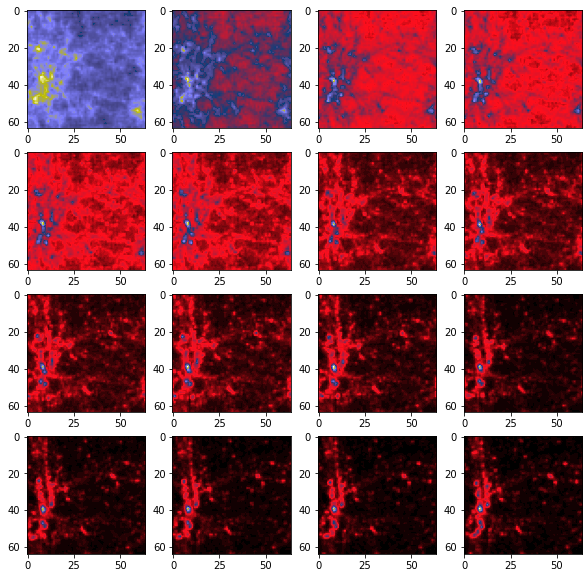

In [ ]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss2[::2][i]).sum(axis=0).max(),vmin=0)

In [ ]:
resi2 = odeint(make_ode_fn(mesh_shape), [poss2[0], vels2[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

In [ ]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss2[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi2[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

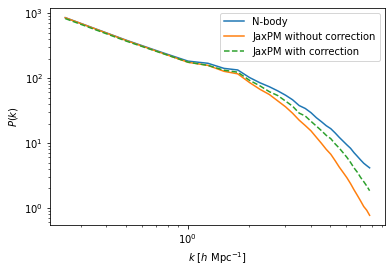

In [ ]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")